# Multiclass Knowledge Engineering Peak Detection in fDOM


In [1]:
# Imports
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sn
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
)
import pandas as pd
import numpy as np
import datetime
import copy
import matplotlib.pyplot as plt
import pickle
import progressbar

import Tools.data_processing as dp
import Tools.data_movement as dm
from Tools.get_all_cands import get_all_cands_turb, get_all_truths

# import classifiers
from Anomaly_Detection.Multiclass_Detection.turbidity_classifiers.turb_PP import (
    turb_PP_Classifier,
)

from Anomaly_Detection.Multiclass_Detection.turbidity_classifiers.turb_FPT import (
    turb_FPT_Classifier,
)

from Anomaly_Detection.Multiclass_Detection.turbidity_classifiers.turb_SKP import (
    turb_SKP_Classifier,
)

# disable warnings
def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn


## Training parameters and helper functions


In [2]:
ITERATIONS = 8000
NUM_SPLITS = 5
AUGMENT_DATA_BEGIN_TIMESTAMP = 2459096.9583333335
USE_AUGMENTED_DATA = True
CLASS_BALANCED_ONLY = True

# for confusion matrix
DATA_LABELS = ["SKP", "PP", "FPT", "NAP"]

# Useful functions
def get_prediction(skp_pred, pp_pred, fpt_pred):
    """
    take the top level prediction based on peak precendence
    """
    if skp_pred == "SKP":
        return skp_pred

    elif pp_pred == "PP":
        return pp_pred

    elif fpt_pred == "FPT":
        return fpt_pred

    else:
        return "NAP"


## Paths to data


In [3]:
# filenames
fdom_raw_data_path = "Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv"
stage_raw_data_path = "Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv"
turb_raw_data_path = (
    "Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv"
)

turb_labeled_path = "Data/labeled_data/ground_truths/turb/turb_all_julian_0k-300k.csv"

turb_raw_augmented_path = "Data/augmented_data/turb/unlabeled/unlabeled_turb.csv"
turb_labeled_augmented_path = "Data/augmented_data/turb/labeled/labeled_turb_peaks.csv"

fdom_augmented_raw_data_path = "Data/augmented_data/turb/unlabeled/unlabeled_fdom.csv"
stage_augmented_data_path = "Data/augmented_data/turb/unlabeled/unlabeled_stage.csv"

# FPT lookup table
turb_fpt_lookup_path = "Data/augmented_data/turb/fpt_lookup.csv"


In [4]:
# Load data
fDOM_data = dm.read_in_preprocessed_timeseries(fdom_raw_data_path)
stage_data = dm.read_in_preprocessed_timeseries(stage_raw_data_path)
turb_data = dm.read_in_preprocessed_timeseries(turb_raw_data_path)
stage_data = dp.align_stage_to_fDOM(fDOM_data, stage_data)

augmented_fdom_data = np.array(
    dm.read_in_timeseries(fdom_augmented_raw_data_path, True)
)
augmented_turb_data = np.array(dm.read_in_timeseries(turb_raw_augmented_path, True))
augmented_stage_data = np.array(dm.read_in_timeseries(stage_augmented_data_path, True))


## Get candidates and truths

The following cell loads in raw non-augmented data that is not class-balanced.


In [5]:
cands = get_all_cands_turb(turb_raw_data_path, turb_labeled_path)

truths = get_all_truths(turb_labeled_path)

assert truths.shape == cands.shape

print(f"Total number of original data candidates: {cands.shape[0]}")


Total number of original data candidates: 1253


## Augmented data

The following block appends augmented data into the raw dataset, making classes mostly (but not perfectly!) class balanced.


In [6]:
if USE_AUGMENTED_DATA:
    cands_augmented = get_all_cands_turb(
        turb_raw_augmented_path, turb_labeled_augmented_path, True, turb_fpt_lookup_path
    )

    truths_augmented = get_all_truths(turb_labeled_augmented_path)

    truths_augmented = truths_augmented[
        truths_augmented["idx_of_peak"].isin(cands_augmented["idx_of_peak"])
    ]

    assert truths_augmented.shape == cands_augmented.shape

    print(f"Total number of augmented candidates: {cands_augmented.shape[0]}")

    # concatenate two candidates and truths into single list
    cands = pd.concat([cands, cands_augmented])
    truths = pd.concat([truths, truths_augmented])

    # concat augmented raw data to normal raw data, for classifier preprocessing
    turb_total = np.concatenate((turb_data, augmented_turb_data))
    fdom_total = np.concatenate((fDOM_data, augmented_fdom_data))
    stage_total = np.concatenate((stage_data, augmented_stage_data))

# if we aren't using augmented data, make sure classifiers have correct data being passed into them for preprocessing
else:
    turb_total = turb_data
    fdom_total = fDOM_data
    stage_total = stage_data


Total number of augmented candidates: 3663


## Test class-balanced testing

Alternatively, use only augmented data for class-balanced training AND TESTING.


In [7]:
if CLASS_BALANCED_ONLY:
    cands = get_all_cands_turb(
        turb_raw_augmented_path, turb_labeled_augmented_path, True, turb_fpt_lookup_path
    )

    truths = get_all_truths(turb_labeled_augmented_path)

    # align the missing augmented data (FPT, NFPT, FSK, NFSK, some others)
    truths = truths[truths["idx_of_peak"].isin(cands["idx_of_peak"])]

    assert truths.shape == cands.shape

    print(f"Total number of candidates: {cands.shape[0]}")

    turb_total = augmented_turb_data
    fdom_total = augmented_fdom_data
    stage_total = augmented_stage_data


Total number of candidates: 3663


## Convert candidates and truths into lists for the classifiers

Classifiers use python lists, not the dataframes


In [8]:
# Convert cands and truths into lists
cands = cands.values.tolist()

truths = truths.values.tolist()

print(str(len(cands)) + " candidates in provided data.")


3663 candidates in provided data.


## Create Classifiers


In [9]:
pp_classifier = turb_PP_Classifier(
    turb_total, fdom_total, stage_total, AUGMENT_DATA_BEGIN_TIMESTAMP
)


In [10]:
skp_classifier = turb_SKP_Classifier(
    turb_total,
    turb_raw_data_path,
    turb_labeled_path,
    turb_raw_augmented_path,
    turb_labeled_augmented_path,
    augmented_only=True,
)


In [11]:
fpt_classifier = turb_FPT_Classifier(turb_total)


## Training Loop


In [12]:
accumulated_test_metrics = {}

accumulated_test_results = {}

accumulated_best_params = {}

accumulated_cfmxs = {}
accumulated_train_cfmxs = {}
accumulated_accs_train = {}

# split data
tss = TimeSeriesSplit(NUM_SPLITS)

overall_start = datetime.datetime.now()

split = 1
divide_by_zero_errs = 0

for train_val_indices, test_indices in tss.split(cands):
    X_train, y_train = [cands[i] for i in train_val_indices], [
        truths[i] for i in train_val_indices
    ]

    X_test, y_test = [cands[i] for i in test_indices], [truths[i] for i in test_indices]

    max_fold_metric = 0
    max_result = None

    # save accumulated accuracies
    accumulated_accs_train[split] = []

    # print out info for user
    print("\nSplit: ", split)
    split_start = datetime.datetime.now()
    num_pos_test = len(list(filter(lambda x: x[2] != "NAP", y_test)))
    num_pos_train = len(list(filter(lambda x: x[2] != "NAP", y_train)))

    print(f"Num Pos in Test: {num_pos_test}")
    print(f"Num Pos in Train: {num_pos_train}")

    if num_pos_test >= 1 and num_pos_train >= 1:
        # instantiate the progress bar
        pbar = progressbar.ProgressBar(max_value=ITERATIONS)

        # main training loop
        for iteration in range(ITERATIONS):
            params = {}

            params["pp"] = pp_classifier.start_iteration()
            params["skp"] = skp_classifier.start_iteration()
            params["fpt"] = fpt_classifier.start_iteration()

            train_preds = []

            pp_preds = pp_classifier.classify_samples(X_train)
            skp_preds = skp_classifier.classify_samples(X_train)
            fpt_preds = fpt_classifier.classify_samples(X_train)

            for i, pred in enumerate(pp_preds):
                train_pred = get_prediction(
                    skp_preds[i][1],
                    pred[1],
                    fpt_preds[i][1],
                )

                train_preds.append(train_pred)

            bal_acc = balanced_accuracy_score(
                [row[2] for row in y_train],
                [row for row in train_preds],
            )

            acc = accuracy_score(
                [row[2] for row in y_train],
                [row for row in train_preds],
            )

            f1_train = f1_score(
                [row[2] for row in y_train], [row for row in train_preds], average=None
            )

            if acc > max_fold_metric:
                max_fold_metric = acc
                max_result = copy.deepcopy(train_preds)
                accumulated_accs_train[split].append((acc, iteration))

                pp_classifier.got_best_results()
                skp_classifier.got_best_results()
                fpt_classifier.got_best_results()

            pp_classifier.end_of_iteration(y_train)
            skp_classifier.end_of_iteration(y_train)
            fpt_classifier.end_of_iteration(y_train)

            pbar.update(iteration)

        # peak testing
        test_preds = []
        pp_preds = pp_classifier.classify_samples(X_test, True)
        skp_preds = skp_classifier.classify_samples(X_test, True)
        fpt_preds = fpt_classifier.classify_samples(X_test, True)

        for i, pred in enumerate(pp_preds):
            test_pred = get_prediction(
                skp_preds[i][1],
                pred[1],
                fpt_preds[i][1],
            )

            test_preds.append(test_pred)

        ######## GET SCORES ########
        # get confusion matrix
        cfmx = confusion_matrix(
            [row[2] for row in y_test],
            [row for row in test_preds],
            labels=DATA_LABELS,
        )

        # get acc score
        acc_score = accuracy_score(
            [row[2] for row in y_test],
            [row for row in test_preds],
        )

        bal_acc = balanced_accuracy_score(
            [row[2] for row in y_test],
            [row for row in test_preds],
        )

        f1 = f1_score(
            [row[2] for row in y_test],
            [row for row in test_preds],
            average="macro",
        )

        precision = precision_score(
            [row[2] for row in y_test],
            [row for row in test_preds],
            average="macro",
        )

        print(f"\nSplit {split} test Scores: F1: {f1}  BA: {bal_acc}  ACC: {acc_score}")

        accumulated_cfmxs[split] = copy.deepcopy(cfmx)

        accumulated_test_metrics[split] = {
            "f1": f1,
            "acc": acc_score,
            "ba": bal_acc,
            "precision": precision,
        }

        accumulated_test_results[split] = copy.deepcopy(test_preds)

        accumulated_best_params[split] = {
            "PP": copy.deepcopy(pp_classifier.best_params),
            "SKP": copy.deepcopy(skp_classifier.best_params),
            "FPT": copy.deepcopy(fpt_classifier.best_params),
        }

        split += 1

print("\n")

overall_end_time = datetime.datetime.now()


  0% (8 of 8000) |                       | Elapsed Time: 0:00:00 ETA:   0:01:50


Split:  1
Num Pos in Test: 480
Num Pos in Train: 478


  0% (4 of 8000) |                       | Elapsed Time: 0:00:00 ETA:   0:03:30


Split 1 test Scores: F1: 0.4475279590756024  BA: 0.562195186800164  ACC: 0.5229508196721312

Split:  2
Num Pos in Test: 473
Num Pos in Train: 958


  0% (3 of 8000) |                       | Elapsed Time: 0:00:00 ETA:   0:05:10


Split 2 test Scores: F1: 0.4465591093664726  BA: 0.5539074583458978  ACC: 0.5147540983606558

Split:  3
Num Pos in Test: 473
Num Pos in Train: 1431


  0% (2 of 8000) |                       | Elapsed Time: 0:00:00 ETA:   0:06:50


Split 3 test Scores: F1: 0.44022613425944646  BA: 0.5553156990802468  ACC: 0.5131147540983606

Split:  4
Num Pos in Test: 481
Num Pos in Train: 1904


  0% (2 of 8000) |                       | Elapsed Time: 0:00:00 ETA:   0:08:53


Split 4 test Scores: F1: 0.4637069079231655  BA: 0.5712089110814915  ACC: 0.5360655737704918

Split:  5
Num Pos in Test: 468
Num Pos in Train: 2385


 99% (7999 of 8000) |################### | Elapsed Time: 0:28:42 ETA:   0:00:00


Split 5 test Scores: F1: 0.4477175997323103  BA: 0.5613168851027441  ACC: 0.521311475409836




## Display Metrics


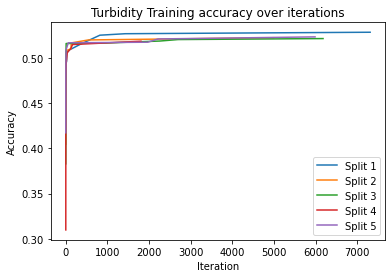

In [13]:
# display training accuracy over iterations
# NOTE: we only save the accuracy if it was an improvement, to restrict the crazy jumps as a result of random grid search
for key in accumulated_accs_train:
    accumulated_accs_train[key] = np.array(accumulated_accs_train[key])
    plt.plot(
        accumulated_accs_train[key][:, 1],
        accumulated_accs_train[key][:, 0],
        label=f"Split {key}",
    )

plt.legend()
plt.title("Turbidity Training accuracy over iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.savefig(
    "Anomaly_Detection/Multiclass_Detection/Experimental_Results/turb/multiclass_training_accuracy.png"
)

plt.show()


Mean Test F1:  0.44914754207139945
Mean Test BA:  0.560788828082109
Mean Test Acc:  0.521639344262295
Mean Test Precision:  0.3886134145898471

Params from split 1:

For peak type PP:
x, value: 10
y, value: 19
inft_range_1, value: (-10, 3)
inft_range_2, value: (-4, -2)
inft_range_3, value: (7, 9)
intf_t1, value: 1.492957698764493
intf_t2, value: 1.5488248843046444

For peak type SKP:
max_basewidth, value: 3
min_prominence, value: 19.588926057389205
downward_bases_threshold, value: 1
proximity_threshold, value: 5

For peak type FPT:
flatness, value: 0.18998381753908059
prominence, value: 52

Params from split 2:

For peak type PP:
x, value: 27
y, value: 6
inft_range_1, value: (1, 3)
inft_range_2, value: (-4, -1)
inft_range_3, value: (9, 11)
intf_t1, value: 1.9833618649617937
intf_t2, value: -1.4261140105225505

For peak type SKP:
max_basewidth, value: 3
min_prominence, value: 19.46584337529138
downward_bases_threshold, value: 4
proximity_threshold, value: 9

For peak type FPT:
flatness,

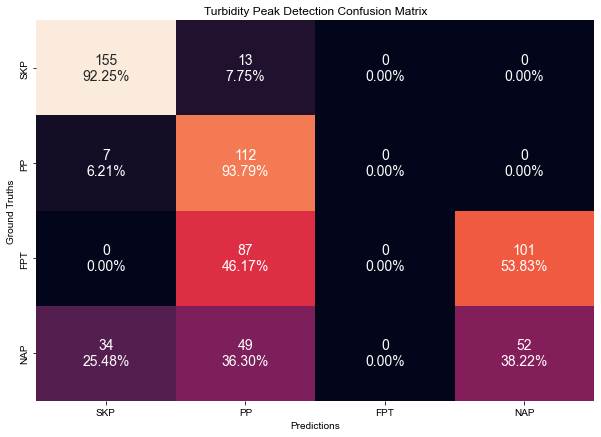

In [14]:
mean_f1 = 0
mean_ba = 0
mean_precision = 0
mean_acc = 0

for key in accumulated_test_metrics:
    metrics = accumulated_test_metrics[key]

    mean_f1 += metrics["f1"]
    mean_ba += metrics["ba"]
    mean_precision += metrics["precision"]
    mean_acc += metrics["acc"]

print("Mean Test F1: ", mean_f1 / len(accumulated_test_metrics))
print("Mean Test BA: ", mean_ba / len(accumulated_test_metrics))
print("Mean Test Acc: ", mean_acc / len(accumulated_test_metrics))
print("Mean Test Precision: ", mean_precision / len(accumulated_test_metrics))

for split in accumulated_best_params.keys():
    print(f"\nParams from split {split}:")
    for peak in accumulated_best_params[split].keys():
        print(f"\nFor peak type {peak}:")

        for param in accumulated_best_params[split][peak].keys():
            print(f"{param}, value: {accumulated_best_params[split][peak][param]}")

# testing conf matrix
mean_cfmx = np.zeros((len(DATA_LABELS), len(DATA_LABELS)))
for key in accumulated_cfmxs.keys():
    mean_cfmx += accumulated_cfmxs[key]

mean_cfmx = mean_cfmx / len(accumulated_cfmxs)

plt.figure(figsize=(10, 7))
plt.title(label="Turbidity Peak Detection Confusion Matrix")

sn.set(font_scale=1.5)

group_counts = ["{0:0.0f}\n".format(value) for value in mean_cfmx.flatten()]
percentages = (mean_cfmx / mean_cfmx.sum(axis=1)[:, np.newaxis]).flatten()
group_percentages = ["{0:.2%}".format(value) for value in percentages]

box_labels = [f"{v2}{v3}".strip() for v2, v3 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(mean_cfmx.shape[0], mean_cfmx.shape[1])

plot = sn.heatmap(
    mean_cfmx.astype("float"),
    annot=box_labels,
    xticklabels=DATA_LABELS,
    yticklabels=DATA_LABELS,
    fmt="",
    cbar=False,
    annot_kws={"size": 14},
)

plot.patch.set_facecolor("xkcd:white")

plt.xlabel("Predictions")
plt.ylabel("Ground Truths")
plt.show()

plot.get_figure().savefig(
    "Anomaly_Detection/Multiclass_Detection/Experimental_Results/turb/conf-matrix.png"
)


In [15]:
with open(
    "Anomaly_Detection/Multiclass_Detection/Experimental_Results/turb/best_params.pkl",
    "wb",
) as pck_file:
    pickle.dump(accumulated_best_params, pck_file)
    pck_file.close()

# Pickle test results
with open(
    "Anomaly_Detection/Multiclass_Detection/Experimental_Results/turb/test_results.pkl",
    "wb",
) as pck_file:
    pickle.dump(accumulated_test_results, pck_file)
    pck_file.close()

# Pickle test metrics
with open(
    "Anomaly_Detection/Multiclass_Detection/Experimental_Results/turb/test_metrics.pkl",
    "wb",
) as pck_file:
    pickle.dump(accumulated_test_metrics, pck_file)
    pck_file.close()


### Statistics from individual classifiers


In [16]:
# print accuracies
print("SKP CLASSIFIER INFO:")
print("ACC: " + str(skp_classifier.best_acc))
print("f1: " + str(skp_classifier.best_f1_score))
print("\n")

print("PP CLASSIFIER INFO:")
print("ACC: " + str(pp_classifier.best_acc))
print("f1: " + str(pp_classifier.best_f1))
print("\n")

print("FPT CLASSIFIER INFO:")
print("ACC: " + str(fpt_classifier.best_acc))
print("f1: " + str(fpt_classifier.best_f1_score))
print("\n")


SKP CLASSIFIER INFO:
ACC: 0.6771585759299013
f1: 0.8039647577092511


PP CLASSIFIER INFO:
ACC: 0.6276818215004641
f1: 0.8193202146690519


FPT CLASSIFIER INFO:
ACC: 0.5010460251046025


AttributeError: 'turb_FPT_Classifier' object has no attribute 'best_f1_score'